In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import fitsio
from astropy.table import Table, vstack
import numpy as np
from pypower import CatalogFFTPower,PowerSpectrumStatistics,setup_logging
from pycorr import TwoPointCorrelationFunction
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#setup_logging()

In [3]:
factor = 5
dk=0.001
k = np.arange(dk/2,0.4+dk*2,dk)
#(k.size // factor) * factor
k[:(k.size // factor) * factor:factor]

array([0.0005, 0.0055, 0.0105, 0.0155, 0.0205, 0.0255, 0.0305, 0.0355,
       0.0405, 0.0455, 0.0505, 0.0555, 0.0605, 0.0655, 0.0705, 0.0755,
       0.0805, 0.0855, 0.0905, 0.0955, 0.1005, 0.1055, 0.1105, 0.1155,
       0.1205, 0.1255, 0.1305, 0.1355, 0.1405, 0.1455, 0.1505, 0.1555,
       0.1605, 0.1655, 0.1705, 0.1755, 0.1805, 0.1855, 0.1905, 0.1955,
       0.2005, 0.2055, 0.2105, 0.2155, 0.2205, 0.2255, 0.2305, 0.2355,
       0.2405, 0.2455, 0.2505, 0.2555, 0.2605, 0.2655, 0.2705, 0.2755,
       0.2805, 0.2855, 0.2905, 0.2955, 0.3005, 0.3055, 0.3105, 0.3155,
       0.3205, 0.3255, 0.3305, 0.3355, 0.3405, 0.3455, 0.3505, 0.3555,
       0.3605, 0.3655, 0.3705, 0.3755, 0.3805, 0.3855, 0.3905, 0.3955])

In [4]:
def get_mean_pk(pk_fns, ells=(0,2,4), remove_shotnoise=True, factor=None, return_shotnoise=False):
    ell0 = []
    ell2 = []
    ell4 = []
    snoise = []
    for fn in pk_fns:
        result = PowerSpectrumStatistics.load(fn)
        if factor is not None: result = result[:(result.shape[0] // factor) * factor:factor]
        k,poles = result(ell=ells, return_k=True, complex=False, remove_shotnoise=remove_shotnoise)
        for i,pole in enumerate(poles):
            if i==0: ell0.append(pole)
            if i==1: ell2.append(pole)
            if i==2: ell4.append(pole)
        snoise.append(result.shotnoise)
    ell0_sigma = np.std(ell0,axis=0)
    ell0 = np.mean(ell0,axis=0)

    ell2_sigma = np.std(ell2,axis=0)
    ell2 = np.mean(ell2,axis=0)

    ell4_sigma = np.std(ell4,axis=0)
    ell4 = np.mean(ell4,axis=0)
    
    pk_mean = [ell0,ell2,ell4]
    pk_sigma = [ell0_sigma,ell2_sigma,ell4_sigma]
    snoise_mean = np.mean(snoise, axis=0)
    if return_shotnoise:
        return k, pk_mean, pk_sigma, snoise_mean
    else:
        return k, pk_mean, pk_sigma

In [5]:
tps = [f'{t}_complete_gtlimaging' for t in ['ELG_LOP','LRG']]#,'QSO']]
tp = 'ELG_LOP_complete_gtlimaging'
mockid = 10
mockdir = f"/pscratch/sd/a/arosado/SecondGenMocks/AbacusSummit/mock{mockid}"

survey_dir = f"/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/"
wts = ['default_FKP']#, 'noweightsys_FKP']

mock_wts = ['default', 'default_cont']
labels = [f"data"]
mocklabels =[f"mock{mockid}",f"mock{mockid}+cont"]
markers = [None, None, None, None]
regions = ['NGC','SGC','GCcomb']
mockls = ['--',':']
ls = ['-']
nran = 4

In [6]:
plot_dir = "plots/v0.6/pk"
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)
    print(f"created dir: {plot_dir}")
    
xiplot_dir = "plots/v0.6/xi"
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)
    print(f"created dir: {plot_dir}")

In [7]:
mydir = f"/pscratch/sd/a/arosado/catalogs/Y1/LSS/iron/LSScats/v0.4/blinded/v0.4_3d/"
survey_dir = f"/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/"

# Pk

ELG_LOP_complete_gtlimaging 0.8_1.1
0.004894411783801143
0.004894411783801143


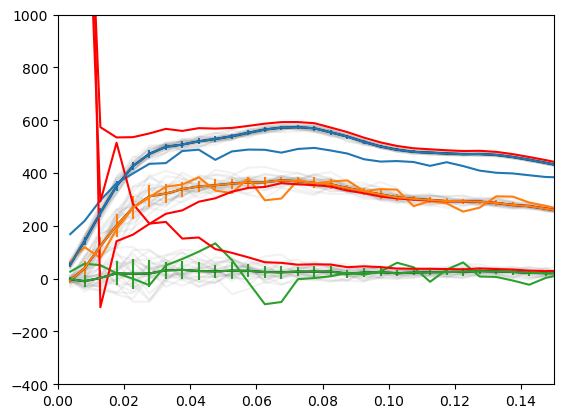

ELG_LOP_complete_gtlimaging 1.1_1.6
0.004894411783801143
0.004894411783801143


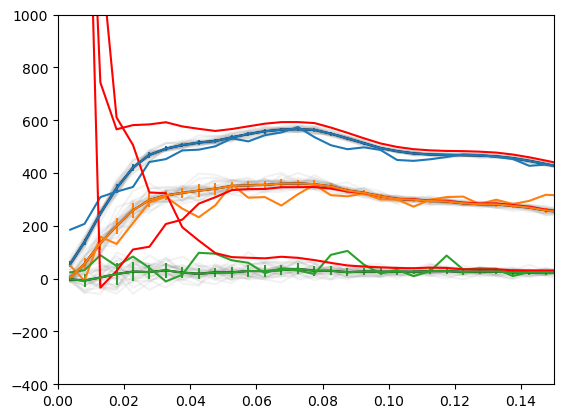

In [8]:
nmocks = 25
factor = 5
reg = 'GCcomb'
for tp in [tps[0]]:
    # redshift bins tracer was trained on
    if tp[:3] == 'ELG':
        zrl = [(0.8,1.1),(1.1,1.6)]
    if tp[:3] == 'QSO':
        zrl = [(0.8,1.3),(1.3,2.1)]# mocks do not have ,(2.1,3.5)] 
    if tp[:3] == 'LRG':
        zrl = [(0.4,0.6),(0.6,0.8),(0.8,1.1)]  
    if tp[:3] == 'BGS':
        zrl = [(0.1,0.4)]
        
    for zl in zrl:
        #ax = plt.gca()
        zw = str(zl[0])+'_'+str(zl[1])
        zmin,zmax = zl[0],zl[1]
        print(tp,zw)
        for wt in ['default_cont','default']:
            pkfns_clean = []
            pks_clean = []
            for mockid in range(nmocks):
                mockdir = f"/pscratch/sd/a/arosado/SecondGenMocks/AbacusSummit/mock{mockid}"
                mock_pkdir = os.path.join(mockdir,'pk')
                mock_pkfn = os.path.join(mock_pkdir, f"pkpoles_{tp}_{reg}_{zw}_{wt}_lin.npy")
                pkfns_clean.append(mock_pkfn)
                if wt=='default':
                    result = PowerSpectrumStatistics.load(mock_pkfn)
                    if factor is not None: 
                        result = result[:(result.shape[0] // factor) * factor:factor]
                    k,poles =result(return_k=True, complex=False)
                    for ic,pole in enumerate(poles):
                        plt.plot(k, k*pole, c=f"grey",alpha=0.1)
            k,pkmean,pkerr = get_mean_pk(pkfns_clean,factor=factor)
            print(k[3]-k[2])
            for i in range(3):
                if wt=='default_cont':plt.errorbar(k,k*pkmean[i],color="r")
                else: 
                    plt.errorbar(k,k*pkmean[i],yerr=k*pkerr[i],color=f"C{i}")
                    plt.plot(k,k*pkmean[i],color="k")
                #plt.errorbar(k,k*pkmean[i],alpha=0.5,color=f"C{i}")#),yerr=k*pkerr[i],alpha=0.5,color=f"C{i}")
            
        for wt in ['default_FKP']:#,'noweightsys_FKP']:
            pkdir = os.path.join(mydir,'pk')
            pkfn = os.path.join(pkdir, f"pkpoles_ELG_LOPnotqso_{reg}_{zw}_{wt}_lin.npy")
            result = PowerSpectrumStatistics.load(pkfn)
            if factor is not None: 
                result = result[:(result.shape[0] // factor) * factor:factor]
            k,poles =result(return_k=True, complex=False)
        for ic,pole in enumerate(poles):
            plt.plot(k, k*pole, c=f"C{ic}")
            
        plt.ylim(-400,1000)
        plt.xlim(0,0.15)
        plt.show()

In [9]:
k

array([0.00370858, 0.00803739, 0.01282278, 0.0177172 , 0.02267563,
       0.02765299, 0.03262336, 0.03759563, 0.04258823, 0.04758582,
       0.05257397, 0.05756732, 0.06256608, 0.06756104, 0.07255718,
       0.07755336, 0.08254421, 0.08754483, 0.09254941, 0.09754667,
       0.10254136, 0.10753557, 0.11253502, 0.11753386, 0.12253296,
       0.12753395, 0.13253111, 0.13752928, 0.14252789, 0.14752683,
       0.15252773, 0.15752749, 0.16252553, 0.16752332, 0.17252211,
       0.17752143, 0.18252233, 0.18752246, 0.19252052, 0.19752023,
       0.20251897, 0.20751876, 0.21252007, 0.21751929, 0.22251971,
       0.22751912, 0.23251778, 0.23751742, 0.24251657, 0.24751676,
       0.25251637, 0.2575144 , 0.26251448, 0.26751616, 0.27251647,
       0.27751607, 0.28251592, 0.287515  , 0.2925142 , 0.29751472,
       0.30251484, 0.30751454, 0.31251403, 0.31751298, 0.32251219,
       0.32751275, 0.33251351, 0.33751207, 0.34251144, 0.34751235,
       0.35251157, 0.35751059, 0.36251138, 0.36751189, 0.37251

ELG_LOP_complete_gtlimaging 0.8_1.1


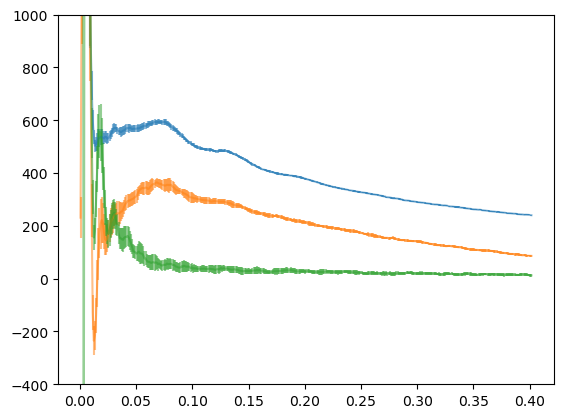

ELG_LOP_complete_gtlimaging 1.1_1.6


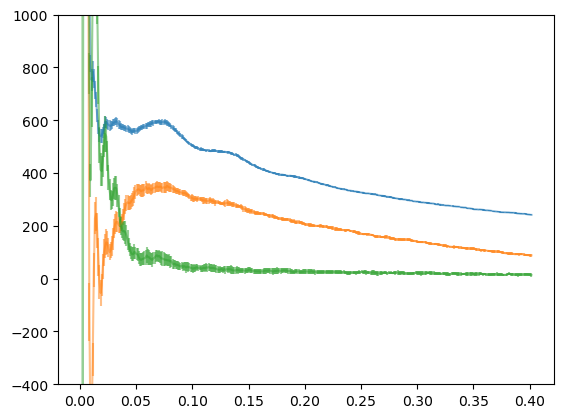

In [19]:
nmocks = 25
reg = 'GCcomb'
for tp in [tps[0]]:
    # redshift bins tracer was trained on
    if tp[:3] == 'ELG':
        zrl = [(0.8,1.1),(1.1,1.6)]
    if tp[:3] == 'QSO':
        zrl = [(0.8,1.3),(1.3,2.1)]# mocks do not have ,(2.1,3.5)] 
    if tp[:3] == 'LRG':
        zrl = [(0.4,0.6),(0.6,0.8),(0.8,1.1)]  
    if tp[:3] == 'BGS':
        zrl = [(0.1,0.4)]
        
    for zl in zrl:
        pkfns_clean = []
        pks_clean = []
        #ax = plt.gca()
        zw = str(zl[0])+'_'+str(zl[1])
        zmin,zmax = zl[0],zl[1]
        print(tp,zw)
        for wt in ['default_cont']:
            for mockid in range(nmocks):
                mockdir = f"/pscratch/sd/a/arosado/SecondGenMocks/AbacusSummit/mock{mockid}"
                mock_pkdir = os.path.join(mockdir,'pk')
                mock_pkfn = os.path.join(mock_pkdir, f"pkpoles_{tp}_{reg}_{zw}_{wt}_lin.npy")
                pkfns_clean.append(mock_pkfn)
                k,pkmean,pkerr = get_mean_pk(pkfns_clean)
            for i in range(3):
                plt.errorbar(k,k*pkmean[i],yerr=k*pkerr[i],alpha=0.5)
        plt.ylim(-400,1000)
        
        plt.show()

ELG_LOP_complete_gtlimaging 0.8_1.1


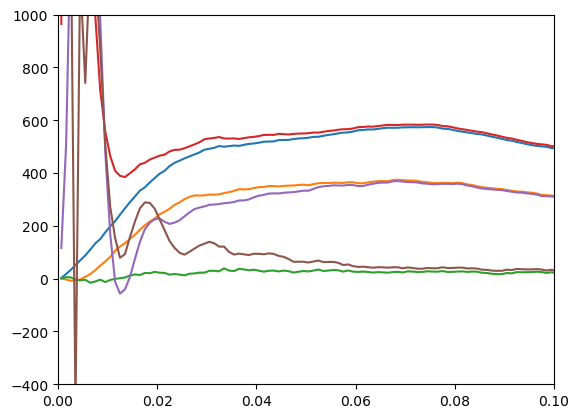

ELG_LOP_complete_gtlimaging 1.1_1.6


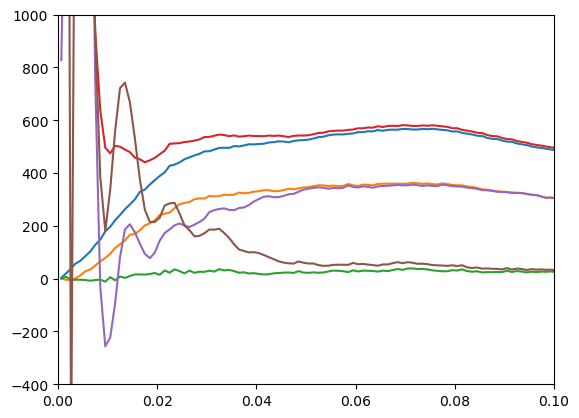

In [45]:
nmocks = 25
reg = 'GCcomb'
for tp in [tps[0]]:
    # redshift bins tracer was trained on
    if tp[:3] == 'ELG':
        zrl = [(0.8,1.1),(1.1,1.6)]
    if tp[:3] == 'QSO':
        zrl = [(0.8,1.3),(1.3,2.1)]# mocks do not have ,(2.1,3.5)] 
    if tp[:3] == 'LRG':
        zrl = [(0.4,0.6),(0.6,0.8),(0.8,1.1)]  
    if tp[:3] == 'BGS':
        zrl = [(0.1,0.4)]
        
    for zl in zrl:
        pkfns_clean = []
        pks_clean = []
        #ax = plt.gca()
        zw = str(zl[0])+'_'+str(zl[1])
        zmin,zmax = zl[0],zl[1]
        print(tp,zw)
        for wt in ['default','default_cont']:
            for mockid in range(nmocks):
                mockdir = f"/pscratch/sd/a/arosado/SecondGenMocks/AbacusSummit/mock{mockid}"
                mock_pkdir = os.path.join(mockdir,'pk')
                mock_pkfn = os.path.join(mock_pkdir, f"pkpoles_{tp}_{reg}_{zw}_{wt}_lin.npy")
                pkfns_clean.append(mock_pkfn)
                k,pkmean,pkerr = get_mean_pk(pkfns_clean,factor=None)
            for i in range(3):
                #plt.errorbar(k,k*pkmean[i],yerr=k*pkerr[i],alpha=0.5)
                plt.plot(k,k*pkmean[i])#,yerr=k*pkerr[i],alpha=0.5)
        plt.ylim(-400,1000)
        plt.xlim(0,0.1)
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ELG_LOP_complete_gtlimaging 0.8_1.1


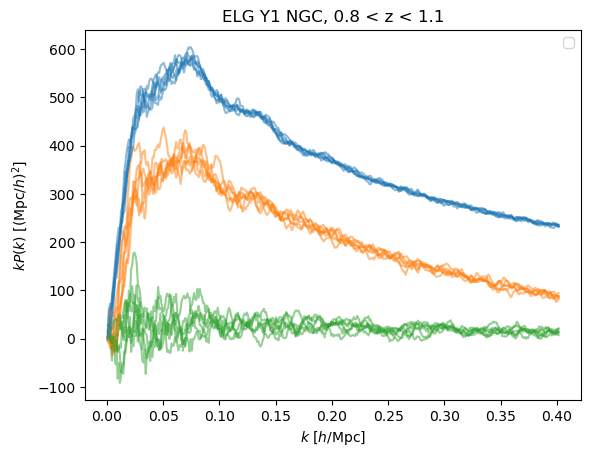

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ELG_LOP_complete_gtlimaging 1.1_1.6


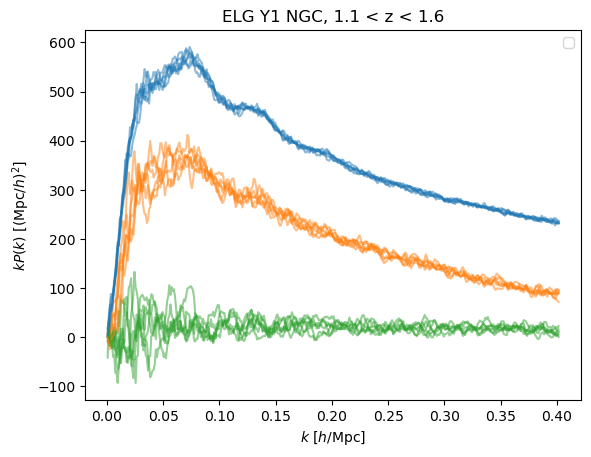

LRG_complete_gtlimaging 0.4_0.6


FileNotFoundError: [Errno 2] No such file or directory: '/pscratch/sd/a/arosado/SecondGenMocks/AbacusSummit/mock0/pk/pkpoles_LRG_complete_gtlimaging_NGC_0.4_0.6_default_lin.npy'

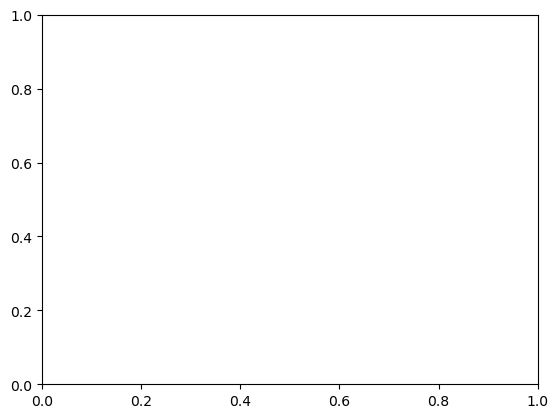

In [54]:
nmocks = 6
reg = 'NGC'
for tp in tps:
    pkfns_clean = []
    pks_clean = []
    # redshift bins tracer was trained on
    if tp[:3] == 'ELG':
        zrl = [(0.8,1.1),(1.1,1.6)]
    if tp[:3] == 'QSO':
        zrl = [(0.8,1.3),(1.3,2.1)]# mocks do not have ,(2.1,3.5)] 
    if tp[:3] == 'LRG':
        zrl = [(0.4,0.6),(0.6,0.8),(0.8,1.1)]  
    if tp[:3] == 'BGS':
        zrl = [(0.1,0.4)]
        
    for zl in zrl:
        ax = plt.gca()
        zw = str(zl[0])+'_'+str(zl[1])
        zmin,zmax = zl[0],zl[1]
        print(tp,zw)
        for mockid in range(nmocks):
            mockdir = f"/pscratch/sd/a/arosado/SecondGenMocks/AbacusSummit/mock{mockid}"
            mock_pkdir = os.path.join(mockdir,'pk')
            mock_pkfn = os.path.join(mock_pkdir, f"pkpoles_{tp}_{reg}_{zw}_default_lin.npy")
            pkfns_clean.append(mock_pkfn)
            result = PowerSpectrumStatistics.load(mock_pkfn)
            k,poles =result(return_k=True, complex=False)
            #pks_clean.append(poles)
            for ic,pole in enumerate(poles):
                ax.plot(k, k*pole, alpha=0.5, c=f"C{ic}")
        #k, poles_mean, poles_sigma = get_mean_pk(pkfns_clean)
        #for ic,pole in enumerate(poles_mean):
        #    print(len(poles_mean),pole)
        #    ax.plot(k, k*pole, c=f"C{ic}")
        ax.set_title(f"{tp[:3]} Y1 {reg}, {zmin} < z < {zmax}")
        ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
        ax.set_ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
        #ax.set_ylim((-400,1000))
        ax.legend(ncol=2)
        plt.show()
                
    